In [1]:
#Getting data from kaggle
from google.colab import files
files.upload()


!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download andrewmvd/face-mask-detection

import zipfile
zip_ref = zipfile.ZipFile('face-mask-detection.zip', 'r')
zip_ref.extractall('/content')

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
100% 398M/398M [00:19<00:00, 24.2MB/s]
100% 398M/398M [00:19<00:00, 21.9MB/s]


In [2]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.2/716.2 kB 14.1 MB/s eta 0:00:00


In [3]:
#Importing modules
from bs4 import BeautifulSoup
import os
import pandas as pd
import random
import shutil
import cv2
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

In [4]:
#Creating a data frame from xml file
data_dictionary={'filename':[],'width':[],'height':[],'name':[],'xmin':[],'ymin':[],'xmax':[],'ymax':[]}

directory_path = '/content/annotations'
directory_files=os.listdir(directory_path)

for file_name in directory_files:

  with open('/content/annotations/'+file_name, 'r') as f:
      file = f.read()

  soup = BeautifulSoup(file, 'xml')
  objects=soup.find_all(['object'])

  for obj in range(len(objects)):
    data_dictionary['filename'].append(soup.find('filename').text)
    data_dictionary['width'].append(soup.find('width').text)
    data_dictionary['height'].append(soup.find('height').text)
    data_dictionary['name'].append(objects[obj].find('name').text)
    data_dictionary['xmin'].append(objects[obj].find('xmin').text)
    data_dictionary['ymin'].append(objects[obj].find('ymin').text)
    data_dictionary['xmax'].append(objects[obj].find('xmax').text)
    data_dictionary['ymax'].append(objects[obj].find('ymax').text)

In [5]:
df=pd.DataFrame(data_dictionary)
df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax
0,maksssksksss498.png,400,272,with_mask,92,46,112,67
1,maksssksksss498.png,400,272,with_mask,151,59,163,72
2,maksssksksss498.png,400,272,without_mask,166,53,179,67
3,maksssksksss498.png,400,272,without_mask,175,76,188,86
4,maksssksksss498.png,400,272,mask_weared_incorrect,194,57,207,74


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   width     4072 non-null   object
 2   height    4072 non-null   object
 3   name      4072 non-null   object
 4   xmin      4072 non-null   object
 5   ymin      4072 non-null   object
 6   xmax      4072 non-null   object
 7   ymax      4072 non-null   object
dtypes: object(8)
memory usage: 254.6+ KB


In [7]:
columns_to_float = ['width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
df[columns_to_float] = df[columns_to_float].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  4072 non-null   object 
 1   width     4072 non-null   float32
 2   height    4072 non-null   float32
 3   name      4072 non-null   object 
 4   xmin      4072 non-null   float32
 5   ymin      4072 non-null   float32
 6   xmax      4072 non-null   float32
 7   ymax      4072 non-null   float32
dtypes: float32(6), object(2)
memory usage: 159.2+ KB


In [8]:
df['name'].value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: name, dtype: int64

In [9]:
#Calculate X-center, Y-center, bounding box width, bounding box height for YoloV8
df['x_center']=((df['xmax']+df['xmin'])/2)/df['width']
df['y_center']=((df['ymax']+df['ymin'])/2)/df['height']
df['bounding_box_width']=(df['xmax']-df['xmin'])/df['width']
df['bounding_box_height']=(df['ymax']-df['ymin'])/df['height']

In [10]:
df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax,x_center,y_center,bounding_box_width,bounding_box_height
0,maksssksksss498.png,400.0,272.0,with_mask,92.0,46.0,112.0,67.0,0.25500,0.207721,0.0500,0.077206
1,maksssksksss498.png,400.0,272.0,with_mask,151.0,59.0,163.0,72.0,0.39250,0.240809,0.0300,0.047794
2,maksssksksss498.png,400.0,272.0,without_mask,166.0,53.0,179.0,67.0,0.43125,0.220588,0.0325,0.051471
3,maksssksksss498.png,400.0,272.0,without_mask,175.0,76.0,188.0,86.0,0.45375,0.297794,0.0325,0.036765
4,maksssksksss498.png,400.0,272.0,mask_weared_incorrect,194.0,57.0,207.0,74.0,0.50125,0.240809,0.0325,0.062500


In [11]:
#Encoding the classes
names_encoder = {'without_mask':'0', 'with_mask':'1', 'mask_weared_incorrect':'2'}
df['name'] = df['name'].map(names_encoder)
df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax,x_center,y_center,bounding_box_width,bounding_box_height
0,maksssksksss498.png,400.0,272.0,1,92.0,46.0,112.0,67.0,0.25500,0.207721,0.0500,0.077206
1,maksssksksss498.png,400.0,272.0,1,151.0,59.0,163.0,72.0,0.39250,0.240809,0.0300,0.047794
2,maksssksksss498.png,400.0,272.0,0,166.0,53.0,179.0,67.0,0.43125,0.220588,0.0325,0.051471
3,maksssksksss498.png,400.0,272.0,0,175.0,76.0,188.0,86.0,0.45375,0.297794,0.0325,0.036765
4,maksssksksss498.png,400.0,272.0,2,194.0,57.0,207.0,74.0,0.50125,0.240809,0.0325,0.062500


In [12]:
#Creating folder containing text files of each image annotations
labels_folder_path='/content/drive/MyDrive/labels/'

os.mkdir(labels_folder_path)

for file in df['filename'].unique().tolist():
  with open(labels_folder_path+file.replace('png', 'txt'), 'w') as f:
    f.write(df[df['filename']==file].to_string(header=False,index=False,columns=['name','x_center',
                                                                                 'y_center','bounding_box_width','bounding_box_height']))

In [13]:
#Choosing random images for train and validation data in list of images_name for each of them for coping files in next steps
images_list=df['filename'].unique().tolist()
val_images=random.sample(images_list,170)
train_images=filtered_list = list(set(images_list).difference(val_images))
len(train_images),len(val_images)

(683, 170)

In [14]:
#Creating Data folder and its inner folders (images,labels) for training and validation
data_folder='/content/drive/MyDrive/data_folder'
images_folder='/content/drive/MyDrive/data_folder/images'
labels_folder='/content/drive/MyDrive/data_folder/labels'
train_folder_images='/content/drive/MyDrive/data_folder/images/train'
val_folder_images='/content/drive/MyDrive/data_folder/images/val'
train_folder_labels='/content/drive/MyDrive/data_folder/labels/train'
val_folder_labels='/content/drive/MyDrive/data_folder/labels/val'
folders_paths=[data_folder,images_folder,labels_folder,train_folder_images,val_folder_images,train_folder_labels,val_folder_labels]
for path in folders_paths:
  os.mkdir(path)

In [15]:
#Copying validation images and labels to val images and val labels folders
for image in val_images:
  shutil.copy('/content/images/'+image,val_folder_images)
  shutil.copy('/content/drive/MyDrive/labels/'+image.replace('png','txt'),val_folder_labels)

In [16]:
#Copying training images and labels to train images and train labels folders
for image in train_images:
  shutil.copy('/content/images/'+image,train_folder_images)
  shutil.copy('/content/drive/MyDrive/labels/'+image.replace('png','txt'),train_folder_labels)

In [17]:
 #Checking the contents of folders we have created
len(os.listdir(train_folder_images)),len(os.listdir(val_folder_images)),len(os.listdir(train_folder_labels)),len(os.listdir(val_folder_labels))

(683, 170, 683, 170)

In [18]:
model=YOLO('yolov8s.yaml')

In [20]:
#Model Training
model.train(data='/content/drive/MyDrive/cfg.yaml', epochs=100,batch=32,imgsz=640,save=True)

Ultralytics YOLOv8.1.19 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/drive/MyDrive/cfg.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 80.2MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 265MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/data_folder/labels/train... 683 images, 0 backgrounds, 0 corrupt: 100%|██████████| 683/683 [00:07<00:00, 85.38it/s] 


train: New cache created: /content/drive/MyDrive/data_folder/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/data_folder/labels/val... 170 images, 0 backgrounds, 0 corrupt: 100%|██████████| 170/170 [00:02<00:00, 57.91it/s]


val: New cache created: /content/drive/MyDrive/data_folder/labels/val.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.39G      4.041      4.686      4.183         74        640: 100%|██████████| 22/22 [00:28<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]

                   all        170        787   5.27e-05     0.0115   2.88e-05   2.88e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.45G      3.334      3.755      3.783         88        640: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        170        787   0.000413     0.0477    0.00032   0.000111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.95G       2.52      2.705      2.783         85        640: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        170        787   0.000123     0.0131   6.49e-05   1.53e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.09G      2.182      2.099      2.218         86        640: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        170        787     0.0023     0.0754    0.00117   0.000463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.99G      2.021      1.897      1.905         93        640: 100%|██████████| 22/22 [00:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        170        787      0.569     0.0598     0.0827     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.71G      1.872      1.623      1.772         83        640: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        170        787      0.605      0.217      0.228      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.98G      1.821      1.502       1.65        130        640: 100%|██████████| 22/22 [00:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all        170        787      0.754      0.299      0.337      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.18G       1.73      1.413      1.623         87        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        170        787      0.853      0.358      0.442      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       8.1G      1.669      1.273      1.532        110        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        170        787       0.77      0.379      0.464      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.84G      1.605      1.184      1.477         64        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

                   all        170        787      0.799      0.405      0.497      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.22G      1.635       1.21      1.488         77        640: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

                   all        170        787      0.779      0.471      0.573      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.42G      1.521      1.085      1.426         96        640: 100%|██████████| 22/22 [00:24<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        170        787      0.794      0.521      0.593      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.49G       1.52       1.07      1.379        118        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        170        787      0.704      0.512      0.569       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.61G      1.498      1.095       1.37         90        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        170        787      0.631      0.509      0.483      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.87G      1.426      1.004      1.345         90        640: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all        170        787       0.75      0.581      0.648       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.99G      1.395     0.9529      1.315        119        640: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        170        787      0.806       0.57      0.655      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         8G      1.424      0.994      1.337         76        640: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        170        787      0.863      0.562      0.694      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.82G      1.386     0.9385      1.311        239        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        170        787       0.66      0.615      0.643      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.03G      1.349     0.9205      1.286         57        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

                   all        170        787      0.828      0.475      0.613      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.63G      1.381     0.9471       1.29         72        640: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        170        787      0.799      0.605      0.707      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.57G      1.363      0.896       1.27         82        640: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        170        787       0.74       0.63      0.713      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.51G      1.358     0.9063      1.263        128        640: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        170        787      0.734      0.586      0.661      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.52G      1.317     0.8959      1.257         75        640: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        170        787      0.752      0.654      0.695      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.37G      1.308     0.8705      1.255         79        640: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        170        787      0.746      0.625      0.731      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       8.1G      1.263     0.8345       1.23         77        640: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        170        787      0.838      0.554      0.715      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       8.7G      1.305     0.8785      1.268         90        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        170        787      0.768      0.666      0.735      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       8.5G      1.268     0.8338       1.24         73        640: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

                   all        170        787      0.729      0.683      0.743      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.97G      1.265     0.8312      1.201        102        640: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

                   all        170        787      0.832       0.61      0.737      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       8.6G      1.292     0.8249      1.228        116        640: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        170        787      0.884      0.586      0.754       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.93G      1.297     0.8402      1.239        140        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        170        787      0.753      0.632      0.703      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.91G      1.291      0.825      1.223         70        640: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all        170        787      0.811      0.602      0.695      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.84G      1.245     0.7765      1.195        102        640: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all        170        787      0.794      0.702      0.758      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.03G      1.207     0.7734      1.206         73        640: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        170        787      0.795      0.632      0.753      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.45G      1.207     0.7688      1.191         94        640: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        170        787      0.805      0.685      0.784       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.87G      1.193     0.7429      1.175         84        640: 100%|██████████| 22/22 [00:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        170        787      0.834      0.649      0.783      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       8.1G      1.211     0.7445      1.184         82        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        170        787      0.827      0.678      0.765      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.13G      1.199     0.7414      1.187         62        640: 100%|██████████| 22/22 [00:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]

                   all        170        787      0.766      0.713       0.76      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.45G      1.165     0.7257      1.171         69        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

                   all        170        787      0.776      0.691      0.764      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.76G      1.212     0.7394      1.172        108        640: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        170        787      0.805      0.726      0.784      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.45G      1.179     0.7214      1.171        141        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all        170        787      0.856      0.653      0.724      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.53G      1.188     0.7395      1.168        102        640: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        170        787      0.855      0.734      0.816      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.49G      1.155     0.7021      1.151        123        640: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        170        787      0.807      0.686      0.789      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       8.9G      1.152     0.7003      1.169         88        640: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        170        787      0.822      0.665      0.775      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.73G      1.155      0.696      1.168         88        640: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        170        787      0.751      0.705       0.77      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.39G      1.149     0.7012      1.158         78        640: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all        170        787       0.83      0.695      0.793      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.76G      1.144      0.701      1.142        144        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

                   all        170        787      0.837      0.759      0.816      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.28G      1.149      0.679      1.149         75        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

                   all        170        787      0.922      0.687      0.795      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.07G      1.149     0.6766      1.136         84        640: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

                   all        170        787      0.759      0.793      0.816      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.63G      1.138     0.6722      1.138         99        640: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        170        787      0.822       0.74       0.81      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.54G      1.104     0.6631      1.136         84        640: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        170        787      0.871       0.72       0.81      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.73G      1.126     0.6578      1.141        132        640: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all        170        787      0.809       0.78      0.819      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.64G      1.119     0.6577       1.15        129        640: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all        170        787      0.842      0.721      0.794      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.71G      1.114     0.6494      1.136         86        640: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        170        787      0.842       0.78      0.836      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.75G      1.117     0.6583      1.126         82        640: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        170        787      0.815      0.767      0.825      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.98G       1.12     0.6538       1.12        113        640: 100%|██████████| 22/22 [00:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all        170        787      0.871       0.75      0.812      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.46G      1.099     0.6321      1.109         89        640: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

                   all        170        787      0.907      0.744      0.845      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.06G      1.079     0.6271      1.119        126        640: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        170        787      0.887      0.759      0.848      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.49G      1.091     0.6278      1.118        171        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all        170        787      0.911      0.725      0.832      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.33G      1.072     0.6158      1.117         61        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        170        787      0.839      0.728       0.82      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.49G      1.074     0.6139      1.099        119        640: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.00it/s]

                   all        170        787       0.87       0.74      0.832      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.67G      1.057      0.612      1.106         44        640: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        170        787      0.858       0.75      0.819      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       8.5G       1.07      0.598      1.107         77        640: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        170        787      0.841       0.79      0.838      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.65G      1.082     0.6171      1.102         77        640: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        170        787      0.893      0.742      0.825      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.91G      1.072     0.6001      1.105        118        640: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        170        787      0.849      0.767      0.817      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.54G      1.044        0.6      1.087         79        640: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

                   all        170        787      0.828      0.769       0.81      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.58G      1.076     0.6032      1.092         70        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

                   all        170        787      0.863      0.776      0.826       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.48G      1.042     0.6042      1.092         73        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all        170        787       0.83      0.776      0.816      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.75G       1.04     0.5884      1.074         91        640: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        170        787      0.834      0.711      0.805      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.56G      1.028     0.5885      1.089         66        640: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        170        787      0.873      0.735      0.816      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.26G      1.016     0.5755      1.075         90        640: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all        170        787      0.896      0.745      0.831      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.27G      1.007     0.5671       1.07         87        640: 100%|██████████| 22/22 [00:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        170        787      0.868      0.778      0.842       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.46G       1.03     0.5827      1.081         76        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]

                   all        170        787      0.891      0.739      0.821       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.41G      1.007     0.5669      1.081         67        640: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        170        787      0.919      0.723      0.827      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.32G      1.029     0.5738      1.074         77        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        170        787      0.892       0.72      0.833      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.92G      1.008     0.5548      1.073        117        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        170        787      0.892      0.752      0.816      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.93G     0.9995     0.5544      1.082         93        640: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        170        787      0.883      0.745      0.825      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.48G      1.014       0.57      1.086         80        640: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        170        787      0.869       0.75      0.813      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.93G      1.001     0.5568      1.068         93        640: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

                   all        170        787      0.913      0.738      0.843      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.11G     0.9915     0.5458      1.072         85        640: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        170        787      0.896      0.763      0.832      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       8.5G     0.9825     0.5528      1.067         75        640: 100%|██████████| 22/22 [00:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        170        787      0.914       0.74      0.829      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.09G     0.9871     0.5502      1.066        101        640: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all        170        787      0.944      0.728      0.831      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.71G     0.9784     0.5513      1.056         68        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        170        787      0.915      0.755      0.844      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.82G      1.007     0.5555      1.053        137        640: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        170        787      0.915      0.722      0.839      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.35G      0.985     0.5446       1.05         78        640: 100%|██████████| 22/22 [00:23<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        170        787      0.874      0.728      0.808      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.88G     0.9673     0.5398      1.061        107        640: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        170        787      0.874      0.779      0.844      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       8.6G     0.9549     0.5267      1.054         91        640: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        170        787      0.939      0.757       0.84      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.41G     0.9584     0.5209      1.048         69        640: 100%|██████████| 22/22 [00:24<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all        170        787      0.899      0.756      0.836      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       8.5G     0.9661     0.5335      1.058         84        640: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

                   all        170        787      0.884      0.773      0.831      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.92G       0.98     0.5319      1.051         88        640: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

                   all        170        787      0.915      0.757      0.833      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.93G     0.9632     0.5289      1.045        108        640: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        170        787      0.896      0.774       0.84      0.573


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.89G     0.9365     0.5044      1.044         33        640: 100%|██████████| 22/22 [00:27<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        170        787      0.889      0.764      0.844      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.42G     0.9249     0.4866       1.04         32        640: 100%|██████████| 22/22 [00:19<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

                   all        170        787      0.896      0.753      0.829      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.48G       0.92     0.4793      1.029         42        640: 100%|██████████| 22/22 [00:20<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        170        787      0.907      0.755      0.834      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.04G     0.9205     0.4763      1.037         74        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all        170        787       0.92      0.761      0.839      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       8.4G     0.9052      0.466      1.035         51        640: 100%|██████████| 22/22 [00:23<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        170        787      0.923      0.748      0.837      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.56G     0.9062     0.4643      1.023         34        640: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        170        787      0.908      0.757      0.839       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.99G     0.8993     0.4741      1.027         24        640: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]

                   all        170        787      0.923      0.755      0.837      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.93G     0.8817     0.4471      1.007         40        640: 100%|██████████| 22/22 [00:20<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        170        787       0.91      0.748      0.836      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.54G     0.8799     0.4583      1.016         61        640: 100%|██████████| 22/22 [00:20<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        170        787      0.923      0.735      0.827      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.92G     0.8923     0.4536      1.005         58        640: 100%|██████████| 22/22 [00:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        170        787      0.865      0.781      0.831      0.564



100 epochs completed in 0.774 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.19 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


                   all        170        787      0.889      0.764      0.844      0.582
          without_mask        170        125      0.827      0.696      0.755      0.482
             with_mask        170        630      0.965      0.878      0.945      0.666
    weared_uncorrectly        170         32      0.875      0.719      0.833      0.598
Speed: 0.3ms preprocess, 4.8ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a7426240c40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [21]:
metrics=model.val()

Ultralytics YOLOv8.1.19 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/MyDrive/data_folder/labels/val.cache... 170 images, 0 backgrounds, 0 corrupt: 100%|██████████| 170/170 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


                   all        170        787      0.854      0.782      0.843      0.582
          without_mask        170        125      0.782      0.704      0.749      0.482
             with_mask        170        630      0.953      0.892      0.948      0.666
    weared_uncorrectly        170         32      0.828       0.75      0.833      0.597
Speed: 1.0ms preprocess, 22.1ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/train22


In [24]:
#Choosing the best weights
final_model=YOLO('/content/drive/MyDrive/runs/detect/train2/weights/best.pt')

In [26]:
#Perdicting and plotting the results
def detect_mask(img_path):
  test_image=cv2.imread(img_path)
  result=final_model.predict(test_image, conf=0.5)
  bounding_box=result[0].boxes.data
  confidence=result[0].boxes.conf.tolist()
  for box, confid in zip(bounding_box,confidence):
    x1, y1, x2, y2,_,class_index= map(int, box)
    color=(255,0,0)
    if class_index==0:
      cv2.rectangle(test_image,(x1,y1),(x2,y2),(255,0,0),1)
      cv2.putText(test_image,f'without_mask:{confid:.2f}',(x1,y1-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color=(255,0,0))
    elif class_index==1:
      cv2.rectangle(test_image,(x1,y1),(x2,y2),(0,255,0),1)
      cv2.putText(test_image,f'with_mask:{confid:.2f}',(x1,y1-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color=(0,255,0))
    else:
      cv2.rectangle(test_image,(x1,y1),(x2,y2),(0,0,255),1)
      cv2.putText(test_image,f'mask_weared_uncorrect:{confid:.2f}',(x1,y1-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color=(0,0,255))
  cv2_imshow(test_image)


0: 352x640 3 with_masks, 11.8ms
Speed: 4.1ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)


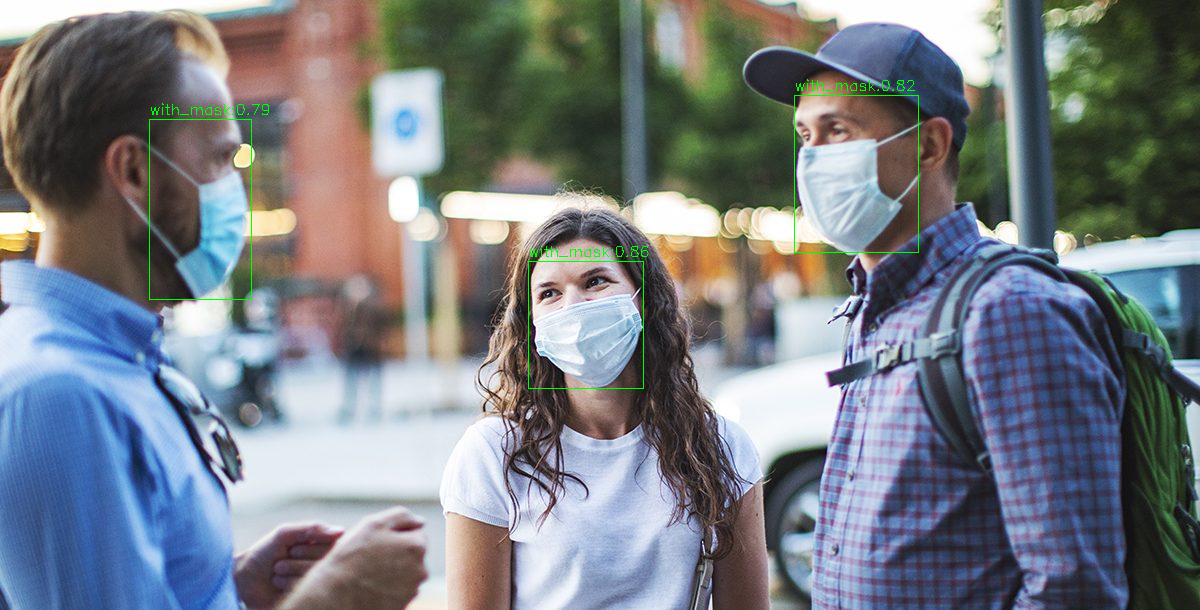

In [27]:
detect_mask('/content/drive/MyDrive/testimg.jpg')


0: 448x640 1 with_mask, 17.6ms
Speed: 2.4ms preprocess, 17.6ms inference, 6.8ms postprocess per image at shape (1, 3, 448, 640)


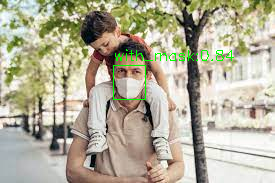

In [28]:
detect_mask('/content/drive/MyDrive/testimg2.jpg')